In [122]:
import os
import glob
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
import json
from astropy.table import Table, Column
from astropy.cosmology import Planck15 as cosmo
from pathlib import Path

# Create object to hold all data
all_data = {}

# Keywords for model parameters and latex symbols
keywords = {
    'plateau_duration': {'key': 'Tpt', 'errkey': 'e_Tpt', 'latex': 'Rest-frame plateau duration (days)'},
    'nickel_mass': {'key': 'MNi', 'errkey': 'e_MNi', 'latex': 'Nickel-56 Ejecta Mass (M$_{\\odot}$)'},
    'host_galaxy': {'key': 'Host'},
    'peak_luminosity': {'key': 'logLpeak', 'errkey': 'e_logLpeak', 'latex': 'Peak Luminosity (log(erg s$^{-1}$))'}
}

blast_keywords = {
    'local_sfd': {'latex': '$\Sigma$SFR ($M_\odot yr^{-1} kpc^{-2}$)'},
    'global_aperture_host_log_mass': {'latex': 'Global Stellar Mass (log($M_\odot$))'},
    'global_aperture_host_log_sfr': {'latex': 'Global Star-Formation Rate (log($M_\odot$ yr$^{-1}$))'},
    'global_aperture_host_log_ssfr': {'latex': 'Global Specific Star-Formation Rate (log(yr$^{-1}$))'},
    'local_aperture_host_logzsol': {'latex': 'Local Metallicity (log($Z/Z_\odot$))'},
    'global_aperture_host_logzsol': {'latex': 'Global Metallicity (log($Z/Z_\odot$))'},
}

<>:23: SyntaxWarning: invalid escape sequence '\S'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
<>:23: SyntaxWarning: invalid escape sequence '\S'
<>:24: SyntaxWarning: invalid escape sequence '\o'
<>:25: SyntaxWarning: invalid escape sequence '\o'
<>:27: SyntaxWarning: invalid escape sequence '\o'
<>:28: SyntaxWarning: invalid escape sequence '\o'
/var/folders/_s/tc8h43192s58wb4s6m2lbfcw0000gn/T/ipykernel_96616/1805289276.py:23: SyntaxWarning: invalid escape sequence '\S'
  'local_sfd': {'latex': '$\Sigma$SFR ($M_\odot yr^{-1} kpc^{-2}$)'},
/var/folders/_s/tc8h43192s58wb4s6m2lbfcw0000gn/T/ipykernel_96616/1805289276.py:24: SyntaxWarning: invalid escape sequence '\o'
  'global_aperture_host_log_mass': {'latex': 'Global Stellar Mass (log($M_\odot$))'},
/var/folders/_s/tc8h43192s58wb4s6m2lbfcw0000gn/T/ipykernel_96616/1805289276.py:2

### Importing data from Valenti+2016 

In [123]:
valenti_phys = Table.read(os.path.join('data','valenti16','valenti_phys_bolometric.tsv'), format='ascii', delimiter='|')
valenti_lcpm = Table.read(os.path.join('data','valenti16','valenti_phys_lcpm.tsv'), format='ascii', delimiter='|')
valenti_meta = Table.read(os.path.join('data','valenti16','valenti_metadata.tsv'), format='ascii', delimiter='|')

# Merge metadata into physical parameters table
for col in valenti_meta.keys():
    if col not in valenti_phys.keys() and col not in ['LC','LC_param']:
        col_data = []
        for row in valenti_phys:
            mask = row['Name']==valenti_meta['Name']
            if len(valenti_meta[mask])==1:
                col_data.append(valenti_meta[mask][0][col])
            else:
                col_data.append(None)
        newcol = Column(col_data, name=col)
        valenti_phys.add_column(newcol)

# Sanitize keywords
for col in valenti_lcpm.keys():
    if col not in valenti_phys.keys() and col not in ['LC','LC_param']:
        col_data = []
        for row in valenti_phys:
            mask = row['Name']==valenti_lcpm['Name']
            if len(valenti_lcpm[mask])==1:
                col_data.append(valenti_lcpm[mask][0][col])
            else:
                col_data.append(None)
        newcol = Column(col_data, name=col)
        valenti_phys.add_column(newcol)

for key in ['MNi','e_MNi','Tpt','e_Tpt']:
    data = []
    for v in valenti_phys[key]:
        try:
            data.append(float(v))
        except TypeError:
            data.append(np.nan)
    valenti_phys[key] = data

# Append complete list of metadata into all_data
valenti_phys.meta['sample_name']='Valenti+2016'
all_data['valenti']=valenti_phys

/var/folders/_s/tc8h43192s58wb4s6m2lbfcw0000gn/T/ipykernel_96616/457811591.py:35: UserWarning: Warning: converting a masked element to nan.
  data.append(float(v))
/var/folders/_s/tc8h43192s58wb4s6m2lbfcw0000gn/T/ipykernel_96616/457811591.py:35: UserWarning: Warning: converting a masked element to nan.
  data.append(float(v))


### Importing data from Spiro+2014 

In [124]:
spiro_data = Table.read(os.path.join('data','spiro14','spiro_nickel'), format='ascii')

# Append complete list of metadata into all_data
spiro_data.meta['sample_name']='Spiro+2014'
all_data['spiro']=spiro_data

### Importing data from Anderson+2014 (https://ui.adsabs.harvard.edu/abs/2014ApJ...786...67A/abstract)

In [125]:
anderson_data = Table.read(os.path.join('data','anderson14','anderson_fit_data.txt'), format='ascii')

# Sanitize MNi-56
mass = [] ; err_mass = [] ; tpt = [] ; err_tpt = []
for row in anderson_data:
    dat = row['MNi']
    if '$' in dat:
        val = float(dat.split('$')[0])
        err = dat.split('$')[1]

        # Strip out brackets from error
        err = err.replace('{','').replace('}','').replace('^','')
        upper, lower = err.split('_')
        upper = np.abs(float(upper)) ; lower = np.abs(float(lower))

        mass.append(val)
        err_mass.append((upper, lower))

    else:
        mass.append(np.nan)
        err_mass.append((np.nan, np.nan))

    # Get plateau duration
    dat = row['OPTd']
    if '(' in dat:
        val, err = dat.split('(')
        tpt.append(float(val))
        err_tpt.append(float(err.replace(')','')))
    else:
        tpt.append(np.nan)
        err_tpt.append(np.nan)

# Get luminosity and uncertainty
all_lum = [] ; elum = []
for row in anderson_data:
     dat = row['M_max']
     dat = dat.replace(')','').replace('*','')

     if '(' not in dat:
         all_lum.append(np.nan)
         elum.append(np.nan)
         continue

     val, err = dat.split('(')
     err = float(err) * 0.4
     lum = np.log10(3.839e33 * 10**(-0.4 * (float(val)-4.74)))

     all_lum.append(lum)
     elum.append(err)

anderson_data.add_column(Column(all_lum, name='logLpeak'))
anderson_data.add_column(Column(elum, name='e_logLpeak'))
    

# Change column names
anderson_data.rename_column('SN','Name')

anderson_data['MNi']=mass
anderson_data.add_column(Column(err_mass, name='e_MNi'))
anderson_data.add_column(Column(tpt, name='Tpt'))
anderson_data.add_column(Column(err_tpt, name='e_Tpt'))

# Add host data from Table 1 data in Anderson+2014
hosts=[]
names=[]
with open(os.path.join('data', 'anderson14','anderson_sample.txt'), 'r') as f:
    for line in f:
        names.append(line.split()[0])
        hosts.append(line.split()[1])

names = np.array(names)
hosts = np.array(hosts)

a_hosts=[]
for row in anderson_data:
    mask = names==row['Name']
    if len(names[mask])==1:
        a_hosts.append(hosts[mask][0])
    else:
        a_hosts.append('--')

anderson_data.add_column(Column(a_hosts, name='Host'))

anderson_data.meta['sample_name']='Anderson+2014'
all_data['anderson']=anderson_data

### Importing data from Martinez+2022 (https://ui.adsabs.harvard.edu/abs/2022A%26A...660A..41M)

In [126]:
martinez_data = Table.read(os.path.join('data','martinez22','table_results.txt'), format='ascii', delimiter='&')

# Sanitize Martinez data so Nickel mass is formatted as a float with error as a tuple
mass = [] ; err_mass = []
for row in martinez_data:
    dat = row['MNi']
    if '$' in dat:
        val = float(dat.split('$')[0])
        err = dat.split('$')[1]

        # Strip out brackets from error
        err = err.replace('{','').replace('}','').replace('^','')
        upper, lower = err.split('_')
        upper = np.abs(float(upper)) ; lower = np.abs(float(lower))

        mass.append(val)
        err_mass.append((upper, lower))

    else:
        mass.append(np.nan)
        err_mass.append((np.nan, np.nan))

martinez_data['MNi']=mass
martinez_data.add_column(Column(err_mass, name='e_MNi'))

# Append complete list of metadata into all_data
martinez_data.meta['sample_name']='Martinez+2022'
all_data['martinez']=martinez_data

### Importing YSE data

In [127]:
yse_data = Table.read(os.path.join('data','yse','yse_data.txt'), format='ascii')

for key in ['e_Tpt','e_MNi']:
    data = []
    for row in yse_data:
        data.append([float(r) for r in row[key].split(',')])
    yse_data[key]=data

yse_data.meta['sample_name']='YSE'
all_data['yse']=yse_data

### Plateau Duration versus Nickel

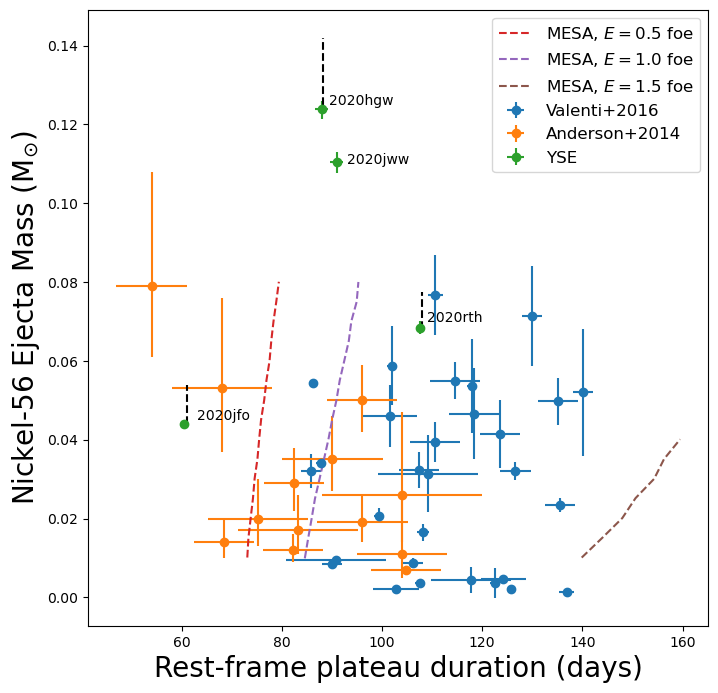

In [128]:
def make_plot(all_data, param1='', param2=''):
    fig, ax = plt.subplots(figsize=(8,8))

    key1=keywords[param1]['key']
    key2=keywords[param2]['key']
    ekey1=keywords[param1]['errkey']
    ekey2=keywords[param2]['errkey']

    for key in all_data.keys():
        table = all_data[key]
        if key1 in table.keys() and key2 in table.keys() and ekey1 in table.keys() and ekey2 in table.keys():
            xerr = np.array(table[ekey1].data)
            yerr = np.array(table[ekey2].data)
            
            if len(xerr.shape)==2:
                xerr = xerr.transpose()
            if len(yerr.shape)==2:
                yerr = yerr.transpose()
            ax.errorbar(table[key1], table[key2], xerr=xerr, yerr=yerr, label=table.meta['sample_name'], fmt='o')

    ax.set_xlabel(keywords[param1]['latex'], fontsize = 20)
    ax.set_ylabel(keywords[param2]['latex'], fontsize = 20)

    return(fig, ax)

fig, ax = make_plot(all_data, 'plateau_duration', 'nickel_mass')

# MESA theoretical data from: https://www.aanda.org/articles/aa/pdf/2020/10/aa38393-20.pdf
# Odd columns are Ni-56 and even columns are plateau duration
colors = ['blue','green','red']
for i,file in enumerate(sorted(glob.glob(os.path.join('data','theory','mesa_nickel*.txt')))):
    filebase = os.path.basename(file)
    value = float(filebase.split('_')[-1].replace('.txt','').replace('foe',''))

    theory_table = Table.read(file, names=('MNi','Tpt'), format='ascii')

    ax.plot(theory_table['Tpt'], theory_table['MNi'], linestyle='dashed', label=f'MESA, $E={value}$ foe')
    
ax.plot([61, 61], [0.044, 0.0538], linestyle = 'dashed', color = 'k')
ax.plot([108, 108], [0.068, 0.0775], linestyle = 'dashed', color = 'k')
ax.plot([88.3, 88.3], [0.125, 0.142], linestyle = 'dashed', color = 'k')
ax.text(63, 0.045, '2020jfo')
ax.text(89.5, 0.125, '2020hgw')
ax.text(93, 0.11, '2020jww')
ax.text(109, 0.07, '2020rth')
ax.legend(fontsize = 'large')

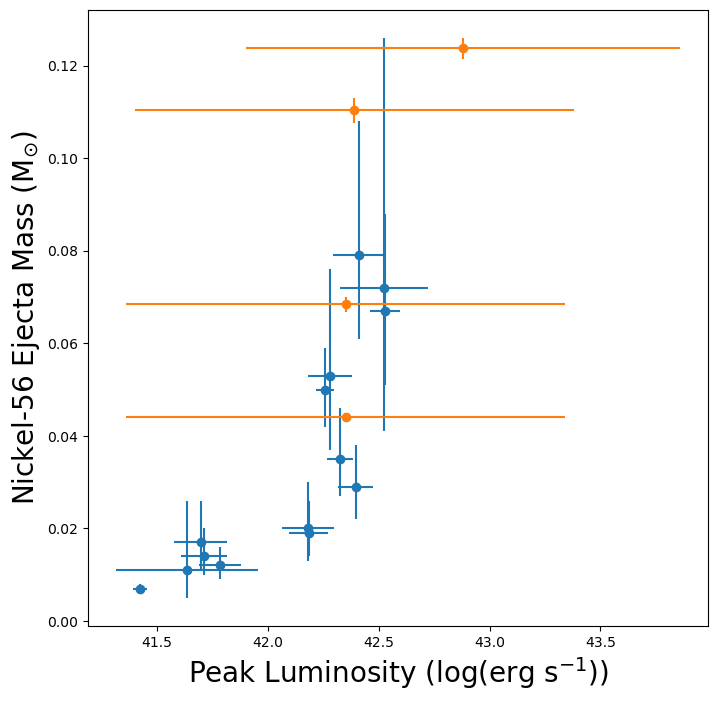

In [129]:
fig, ax = make_plot(all_data, 'peak_luminosity', 'nickel_mass')

In [130]:
import requests

def get_blast_data(name, suppress_output=False):
    fname=os.path.join('data','blast',name+'.json')
    if os.path.exists(fname):
        with open(fname, 'r') as f:
            data = json.load(f)
            return(data)
    else:
        url = f'https://blast.scimma.org/api/transient/get/{name}'
        r = requests.get(url)
        if r.status_code==200:
            data = json.loads(r.content)
            with open(fname, 'w') as f:
                json.dump(data, f)
        else:
            if not suppress_output: print(f'Could not get Blast data for: {name}')

Could not get Blast data for: 2013ai
Could not get Blast data for: 2013bu
Could not get Blast data for: LSQ13dpa
Could not get Blast data for: 2014dw
Could not get Blast data for: LSQ14gv
Could not get Blast data for: ASASSN-14dq
Could not get Blast data for: ASASSN-14gm
Could not get Blast data for: ASASSN-14ha
Redshift for 2015W is missing
Could not get Blast data for: 2013ab
Could not get Blast data for: 1987A
Could not get Blast data for: 1990E
No local aperture for 2001X
Could not get Blast data for: 2002hh
Could not get Blast data for: 2003hd
Could not get Blast data for: 2003hn
Redshift for 2004et is missing
Redshift for 2005cs is missing
Could not get Blast data for: 2007it
Could not get Blast data for: 2007od
Could not get Blast data for: 2008fq
Could not get Blast data for: 2008in
Could not get Blast data for: 2009N
Redshift for 2009bw is missing
Could not get Blast data for: 2009dd
Redshift for 2012A is missing
Could not get Blast data for: 2013ai
Could not get Blast data fo

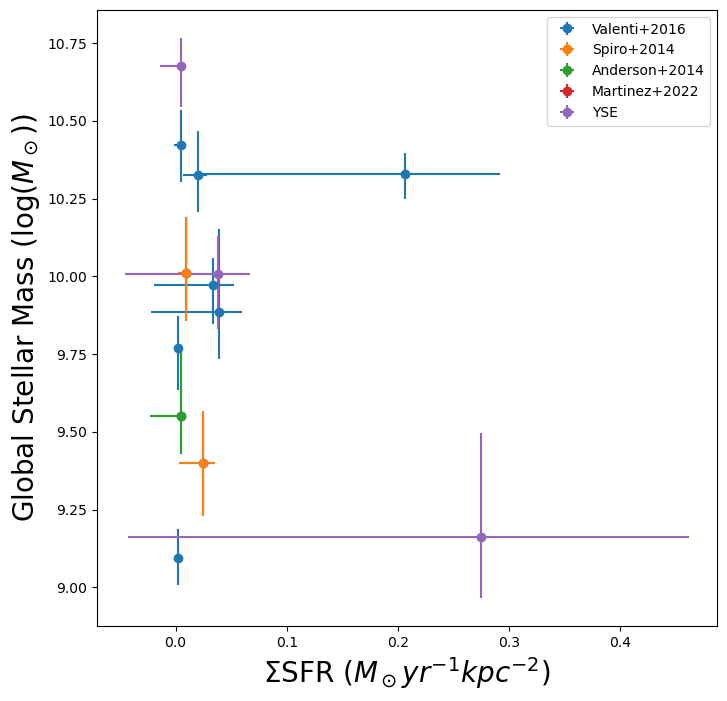

In [131]:
def get_local_sfd(data, suppress_output=False):

    # Return a contextual error to flag objects that need to be re-run
    error = ''
    
    # Get area of local aperture in kpc^2
    redshift = data['host_redshift']
    if redshift is None:
        name = data['transient_name']
        if not suppress_output: print(f'Redshift for {name} is missing')
        return(np.nan, (np.nan, np.nan), 'redshift')
        
    a = data['local_aperture_semi_major_axis_arcsec']
    b = data['local_aperture_semi_minor_axis_arcsec']

    if a is None or b is None:
        name = data['transient_name']
        if not suppress_output: print(f'No local aperture for {name}')
        return(np.nan, (np.nan, np.nan), 'local_aperture')

    d = cosmo.angular_diameter_distance(redshift).value * 1000.0 # Convert to kpc
    area = np.pi * a/3600 * np.pi/180.0 * d * b/3600 * np.pi/180.0 * d

    # Get local star-formation rate
    val = data['local_aperture_host_log_sfr_50']
    if val is None:
        return(np.nan, (np.nan, np.nan), 'local_aperture')

    val = 10**val
    
    eup = 10**data['local_aperture_host_log_sfr_84'] - val
    elo = val - 10**data['local_aperture_host_log_sfr_16']

    val = val / area
    unc = (eup/area, elo/area)

    return(val, unc, error)
    

def make_blast_plot(all_data, param1, param2, suppress_output=False):
    fig, ax = plt.subplots(figsize=(8,8))

    blast1=False
    blast2=False

    blast_errors = {}

    if param1 in keywords.keys():
        key1=keywords[param1]['key']
        ekey1=keywords[param1]['errkey']
        latex1=keywords[param1]['latex']
    elif param1.startswith('global') or param1.startswith('local'):
        latex1=blast_keywords[param1]['latex']
        blast1=True
    if param2 in keywords.keys():
        key2=keywords[param2]['key']
        ekey2=keywords[param2]['errkey']
        latex2=keywords[param2]['latex']
    elif param2.startswith('global') or param2.startswith('local'):
        latex2=blast_keywords[param2]['latex']
        blast2=True

    for key in all_data.keys():
        table = all_data[key]

        if not blast1 and key1 in table.keys() and ekey1 in table.keys():
            x = np.array(table[key1].data)
            xerr = np.array(table[ekey1].data)

        elif blast1:
            x = [] ; xerr = []
            for row in table:
                data = get_blast_data(row['Name'], suppress_output=suppress_output)

                if data is None:
                    if row['Name'] not in blast_errors.keys():
                        blast_errors[row['Name']]='missing'
                    x.append(np.nan)
                    xerr.append((np.nan, np.nan))
                    continue

                if param1=='local_sfd':
                    val, unc, error = get_local_sfd(data, suppress_output=suppress_output)
                    if error:
                        if row['Name'] not in blast_errors.keys():
                            blast_errors[row['Name']]=error
                else:
                    val = data[param1+'_50']
                    if val is None:
                        x.append(np.nan)
                        xerr.append((np.nan, np.nan))
                        continue
                    eup = data[param1+'_84']-val
                    elo = val - data[param1+'_16']
                    unc = (eup, elo)

                x.append(val)
                xerr.append(unc)
        else:
            continue

        if not blast2 and key2 in table.keys() and ekey2 in table.keys():
            y = np.array(table[key2].data)
            yerr = np.array(table[ekey2].data)

        elif blast2:
            y = [] ; yerr = []
            for row in table:
                data = get_blast_data(row['Name'], suppress_output=suppress_output)

                if data is None:
                    if row['Name'] not in blast_errors.keys():
                        blast_errors[row['Name']]='missing'
                    y.append(np.nan)
                    yerr.append((np.nan, np.nan))
                    continue

                if param2=='local_sfd':
                    val, unc, error = get_local_sfd(data, suppress_output=suppress_output)
                    if error:
                        if row['Name'] not in blast_errors.keys():
                            blast_errors[row['Name']]=error
                else:
                    val = data[param2+'_50']
                    if val is None:
                        y.append(np.nan)
                        yerr.append((np.nan, np.nan))
                        continue
                    eup = data[param2+'_84']-val
                    elo = val - data[param2+'_16']
                    unc = (eup, elo)

                y.append(val)
                yerr.append(unc)
        else:
            continue

        xerr = np.array(xerr)
        yerr = np.array(yerr)

        if len(xerr.shape)==2:
            xerr = xerr.transpose()
        if len(yerr.shape)==2:
            yerr = yerr.transpose()

        ax.errorbar(x, y, xerr=xerr, yerr=yerr, label=table.meta['sample_name'], fmt='o')

    ax.set_xlabel(latex1, fontsize = 20)
    ax.set_ylabel(latex2, fontsize = 20)

    return(fig, ax, blast_errors)
    

fig, ax, errors = make_blast_plot(all_data, 'local_sfd', 'global_aperture_host_log_mass')
plt.legend()

In [132]:
yse_transients_ref = Table.read(os.path.join('data','transients.ref'), format='ascii')

outfile = open('blast_missing.txt', 'w')

for key in errors.keys():
    if errors[key]=='missing':
        mask = yse_transients_ref['name']==key
        if len(yse_transients_ref[mask])==1:
            ra = yse_transients_ref[mask][0]['ra']
            dec = yse_transients_ref[mask][0]['dec']
            print(key, ra, dec)
            outfile.write(f'{key} {ra} {dec} \n')
outfile.close()

2013ai 94.07645833333332 -21.375805555555555
2013bu 339.259041666667 34.4014444444444
2014dw 167.701708333333 -37.4506111111111
2013ab 218.185375 9.88675
1987A 83.86675 -69.2697416666667
1990E 39.87125 -8.13722222222222
2002hh 308.684541666667 60.1219444444444
2003hd 27.4429583333333 -21.9105
2003hn 56.1504166666667 -44.6302777777778
2007it 214.606791666667 -43.3816111111111
2007od 358.952833333333 18.4152222222222
2008fq 306.275791666667 -24.8076666666667
2008in 185.507375 4.47986111111111
2009N 187.789416666667 -8.04897222222222
2009dd 181.392083333333 50.5385
1994N 157.445 13.0202777777778
1997D 62.7541666666667 -56.4988888888889
1999br 195.174166666667 2.49605555555556
1999eu 41.586625 -30.3183611111111
2001dc 222.81754166666664 58.98416944444445
2002gd 348.654208333333 4.50169444444444
2004eg 67.0344166666667 21.6550833333333
2006ov 185.480416666667 4.48797222222222
1986L 64.3725 -62.7844444444444
1991al 295.600291666667 -55.1065277777778
1992ad 186.706625 8.87741666666667
1992af 

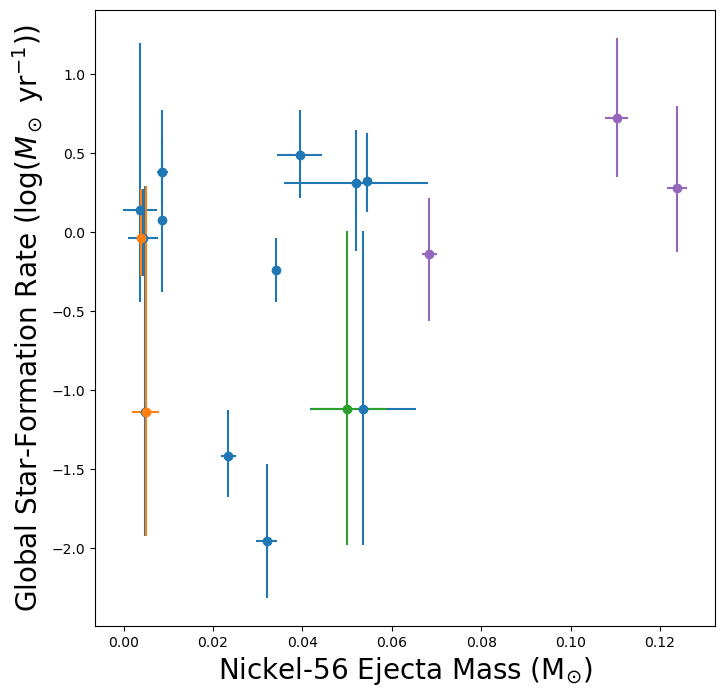

In [133]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass','global_aperture_host_log_sfr', suppress_output=True)
plt.legend()

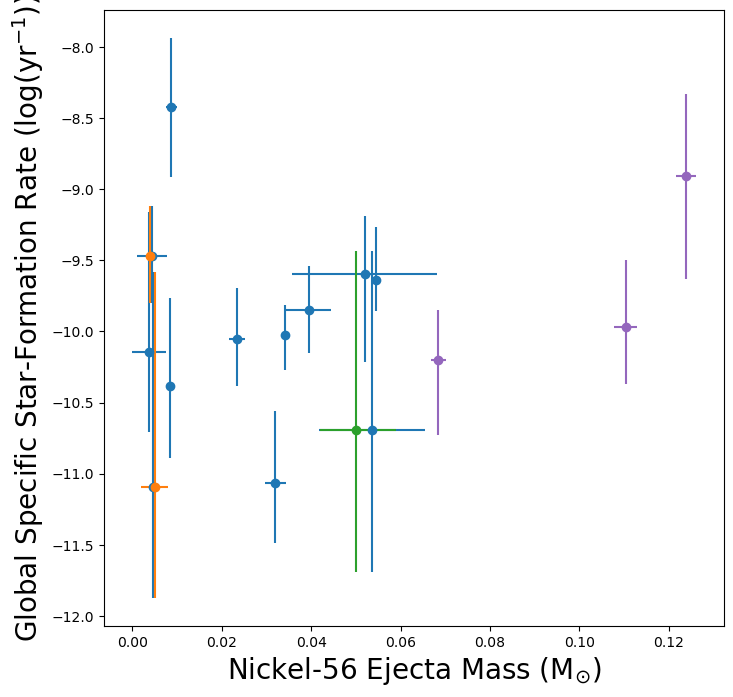

In [134]:
fig, ax, errors = make_blast_plot(all_data, 'nickel_mass','global_aperture_host_log_ssfr', suppress_output=True)
plt.legend()

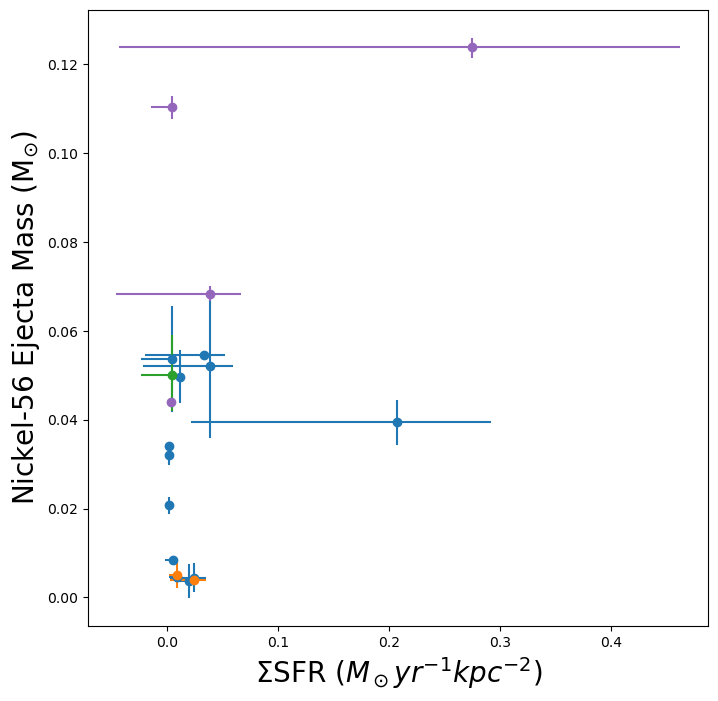

In [135]:
fig, ax, errors = make_blast_plot(all_data, 'local_sfd','nickel_mass', suppress_output=True)
plt.legend()

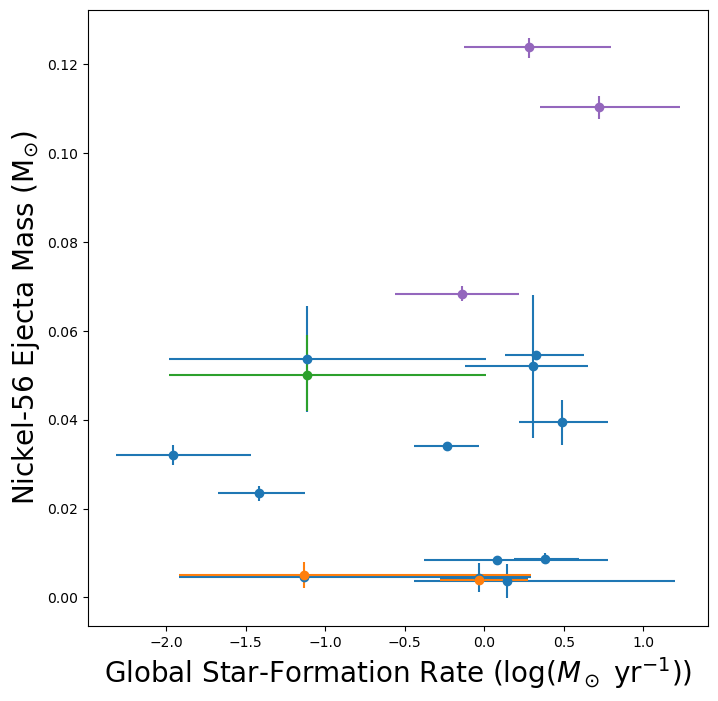

In [136]:
fig, ax, errors = make_blast_plot(all_data, 'global_aperture_host_log_sfr','nickel_mass', suppress_output=True)
plt.legend()

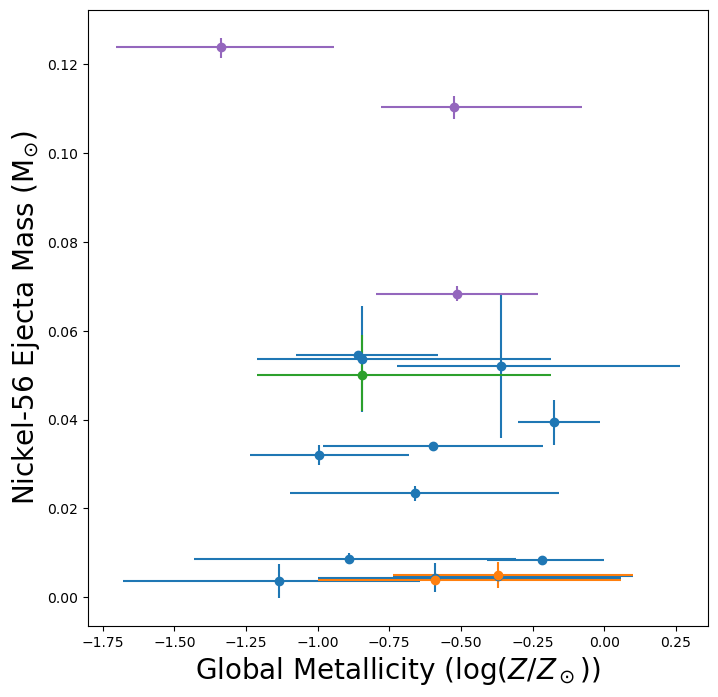

In [137]:
fig, ax, errors = make_blast_plot(all_data, 'global_aperture_host_logzsol','nickel_mass', suppress_output=True)
plt.legend()

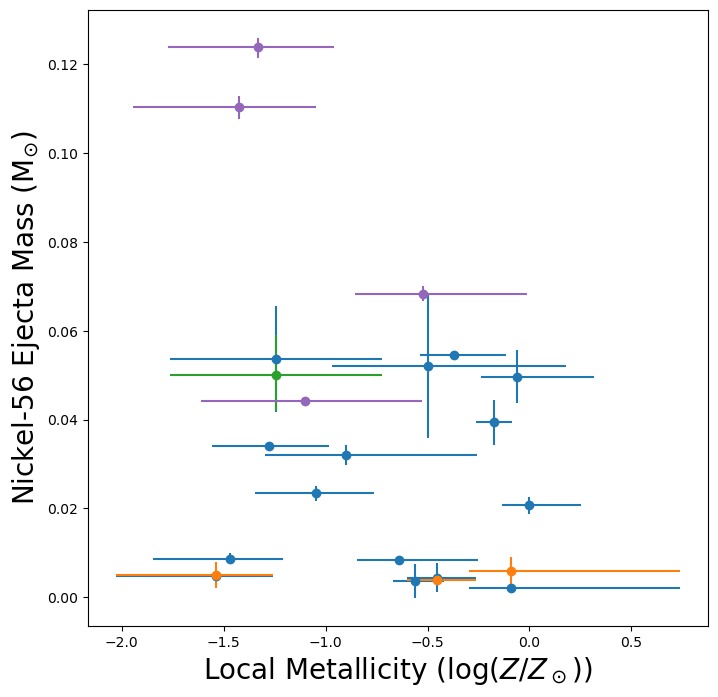

In [138]:
fig, ax, errors = make_blast_plot(all_data, 'local_aperture_host_logzsol','nickel_mass', suppress_output=True)
plt.legend()

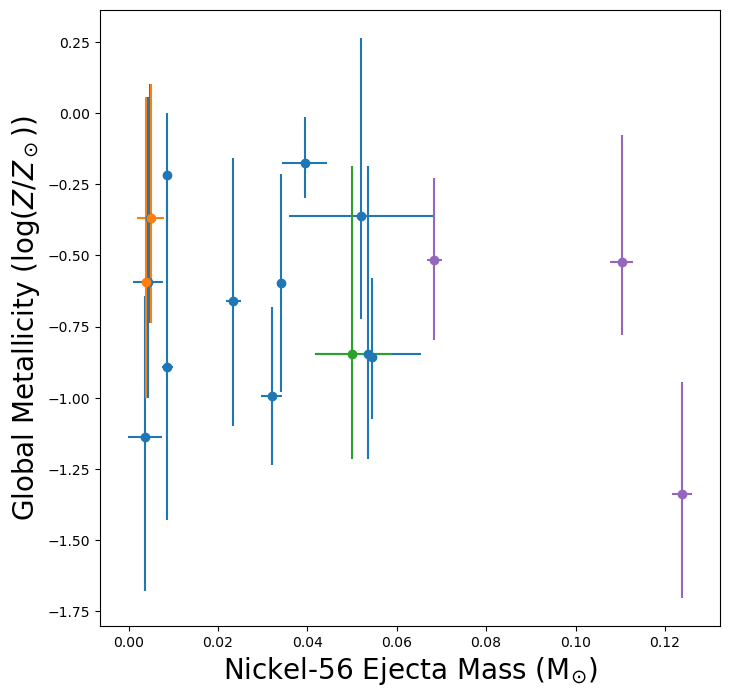

In [139]:
fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'global_aperture_host_logzsol', suppress_output=True)
plt.legend()

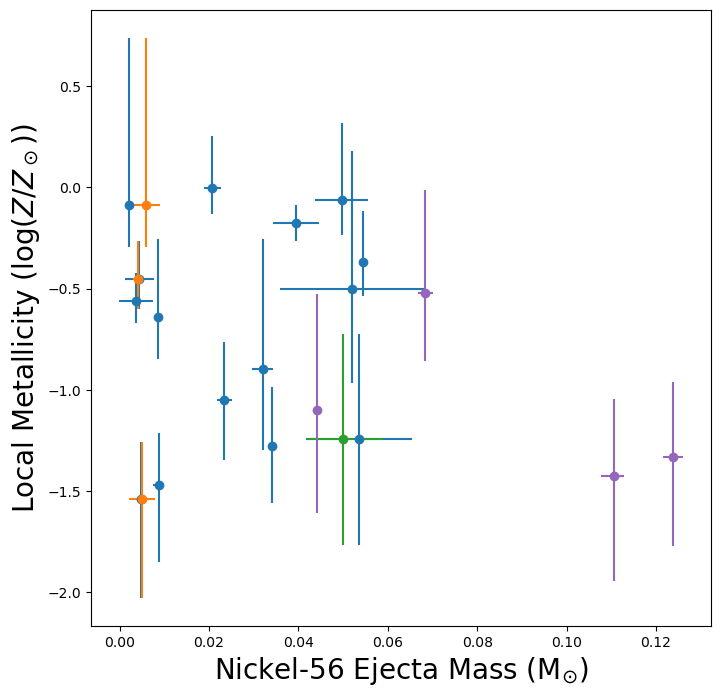

In [140]:
fig, ax, errors = make_blast_plot(all_data,'nickel_mass', 'local_aperture_host_logzsol', suppress_output=True)
plt.legend()